## import

In [381]:
from src.config.config import Config
from src.db_writer.db import DB
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [382]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12.8, 7.2)

In [383]:
# config = Config()
# db = DB(config)

In [384]:
# BTC_current_quarter = pd.read_sql('SELECT * FROM `exchange data`.BTC_current_quarter;', con=db.con)
# BTC_current_quarter.to_csv('BTC_current_quarter.csv')

# BTC_perpetual = pd.read_sql('SELECT * FROM `exchange data`.BTC_perpetual;', con=db.con)
# BTC_perpetual.to_csv('BTC_perpetual.csv')

# BTC_cq_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_cq_bid_ask;', con=db.con)
# BTC_cq_bid_ask.to_csv('BTC_cq_bid_ask.csv')

# BTC_perp_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_perp_bid_ask;', con=db.con)
# BTC_perp_bid_ask.to_csv('BTC_perp_bid_ask.csv')

In [385]:
# db.close_all()

In [386]:
BTC_current_quarter = pd.read_csv('BTC_current_quarter.csv', index_col=[0])
BTC_perpetual = pd.read_csv('BTC_perpetual.csv', index_col=[0])
BTC_cq_bid_ask = pd.read_csv('BTC_cq_bid_ask.csv', index_col=[0])
BTC_perp_bid_ask = pd.read_csv('BTC_perp_bid_ask.csv', index_col=[0])

In [387]:
df_total = BTC_perpetual.merge(BTC_perp_bid_ask.drop('funding_rate', axis=1), on='timestamp')\
        .merge(
                BTC_current_quarter.merge(BTC_cq_bid_ask.drop('time_left', axis=1), on='timestamp'),
                on = 'timestamp',
                suffixes=['_perp', '_cq']
        )

## EDA

### time_left check. (Valid for train-test, but in general needs fix)

In [388]:
temp = pd.concat([
    pd.to_datetime(df_total['timestamp'], unit='s'),
    pd.to_datetime(df_total['timestamp'] + df_total['time_left'], unit='s'),
], axis=1)

In [389]:
temp = pd.concat([
    pd.to_datetime(BTC_current_quarter['timestamp'], unit='s'),
    pd.to_datetime(BTC_current_quarter['timestamp'] + BTC_current_quarter['time_left'], unit='s'),
], axis=1)

In [390]:
temp[0].unique()

array(['2021-03-26T08:00:00.000000000', '2021-06-25T05:00:00.000000000',
       '2021-06-25T08:00:00.000000000', '2021-09-24T05:00:00.000000000',
       '2021-09-24T08:00:00.000000000', '2021-12-31T06:00:00.000000000',
       '2021-12-31T08:00:00.000000000', '2022-03-25T06:00:00.000000000',
       '2022-03-25T08:00:00.000000000', '2022-06-24T05:00:00.000000000',
       '2022-06-24T08:00:00.000000000', '2022-09-30T05:00:00.000000000',
       '2022-09-30T08:00:00.000000000', '2022-12-30T08:00:00.000000000',
       '2023-03-31T08:00:00.000000000', '2023-06-30T08:00:00.000000000'],
      dtype='datetime64[ns]')

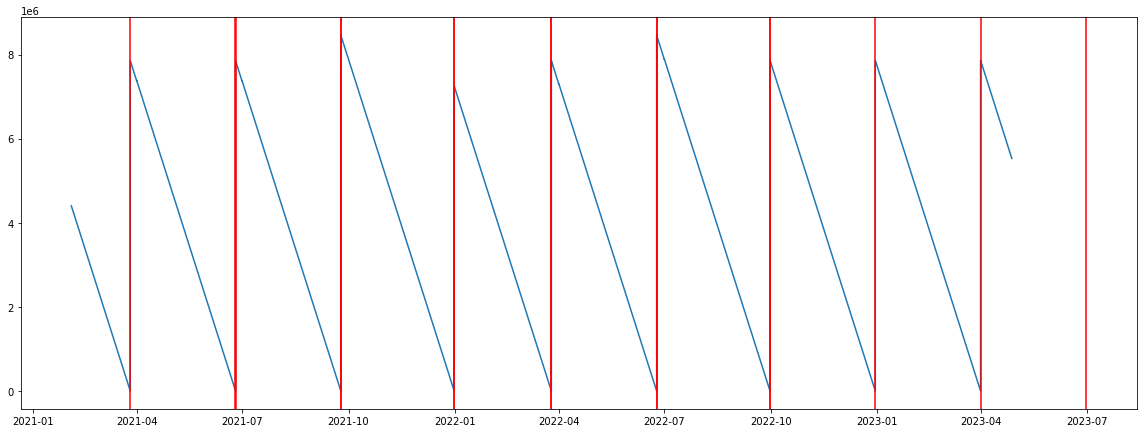

In [391]:
plt.figure(figsize=(20, 7.2))
plt.plot(temp['timestamp'], BTC_current_quarter['time_left'])
for i in (pd.to_datetime(BTC_current_quarter['timestamp'] + BTC_current_quarter['time_left'], unit='s').unique()):
    plt.axvline(i, c='r')

In [392]:
# plt.figure(figsize=(12.8, 7.2))
# plt.plot(temp['timestamp'], df_total['time_left'])
# for i in (pd.to_datetime(df_total['timestamp'] + df_total['time_left'], unit='s').unique()):
#     plt.axvline(i, c='r')

In [393]:
df_total.head()

,timestamp,open_perp,max_perp,min_perp,close_perp,volume_perp,number_of_trades_perp,funding_rate,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,open_cq,max_cq,min_cq,close_cq,volume_cq,number_of_trades_cq,time_left,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq
0,1661248680,21476.3,21479.8,21466.3,21466.4,70.275,695,0.000011,21476.2,8.013,21476.3,6.975,21511.1,21511.1,21500.7,21503.9,0.415,5,3276120.0,21502.4,0.019,21508.0,0.071
1,1661248740,21459.7,21459.7,21456.7,21456.7,16.934,210,0.000012,21459.1,3.420,21459.2,14.399,21493.2,21493.2,21487.4,21487.4,0.008,2,3276060.0,21487.4,0.019,21493.3,0.050
2,1661248800,21430.3,21440.8,21426.8,21426.8,100.950,847,0.000012,21432.6,0.820,21434.3,0.004,21459.9,21459.9,21455.7,21455.7,0.024,2,3276000.0,21456.4,0.169,21462.8,0.071
3,1661248860,21445.0,21446.7,21434.9,21435.0,100.036,621,0.000011,21444.9,25.023,21445.0,1.005,21476.7,21476.7,21462.9,21462.9,0.387,13,3275940.0,21476.7,0.100,21478.3,0.054
4,1661248920,21445.0,21448.6,21442.9,21442.9,33.527,492,0.000010,21444.9,17.361,21445.0,1.806,21479.4,21479.5,21472.6,21472.6,0.047,5,3275880.0,21471.6,0.019,21476.5,0.121


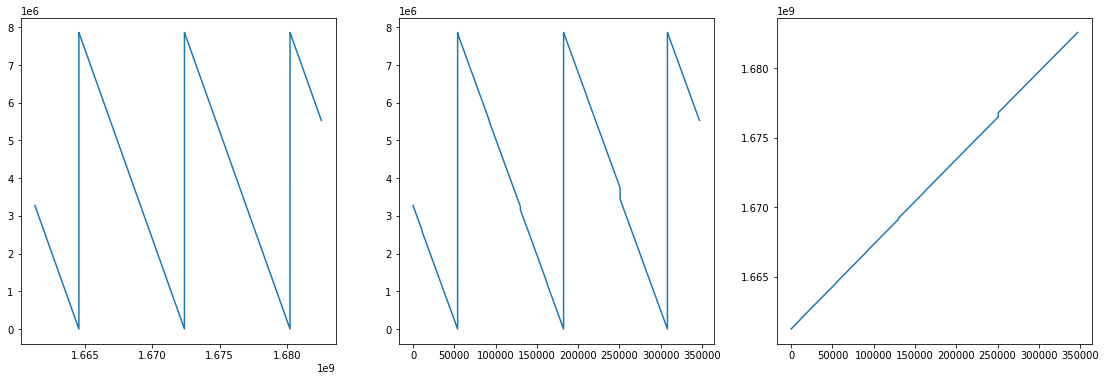

In [394]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(19.2, 6))
ax1.plot(df_total['timestamp'], df_total['time_left'])
ax2.plot(df_total['time_left'])
ax3.plot(df_total['timestamp'])
plt.show()

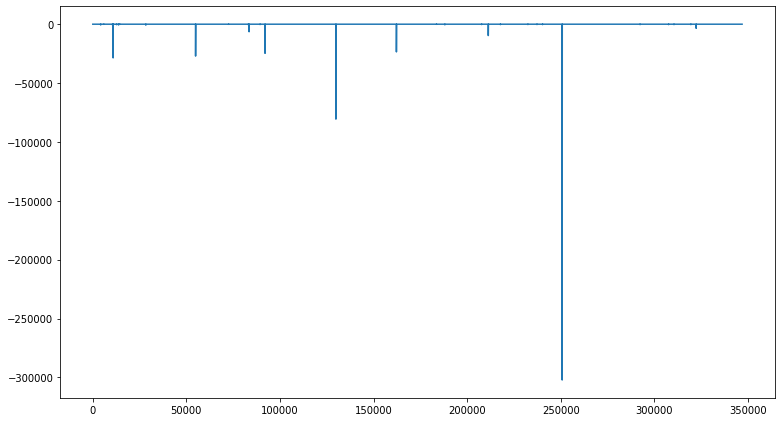

In [395]:
plt.figure(figsize=(12.8, 7.2))
temp = df_total['time_left'].diff()
plt.plot(temp[temp<7861979])

(0.0, 32000.0)

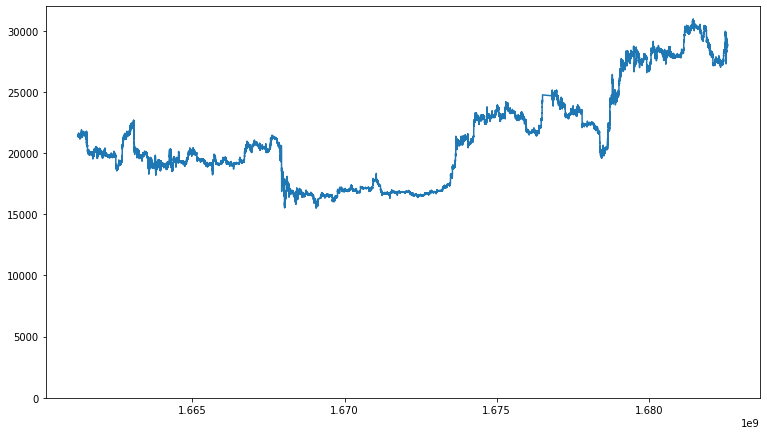

In [396]:
plt.figure(figsize = (12.8, 7.2))
plt.plot(df_total['timestamp'], df_total['open_perp'])
plt.ylim([0, 32000])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_cq'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])

### other features overview

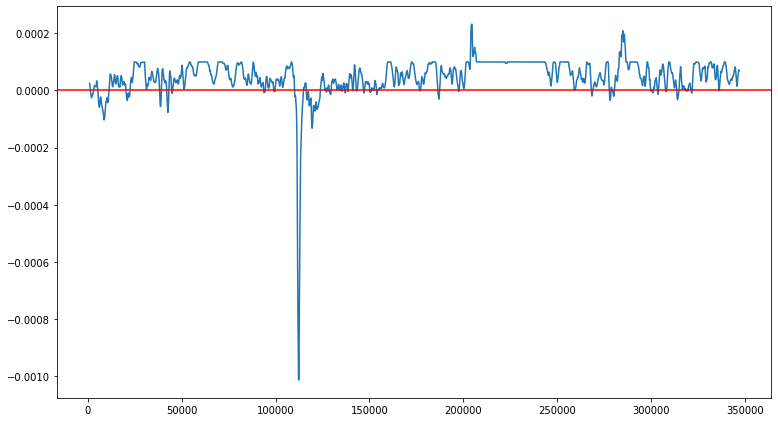

In [397]:
# plt.plot(df_total['funding_rate'])
plt.plot(df_total['funding_rate'].rolling(1000).mean())
plt.axhline(0, c = 'r')

In [398]:
df_total.head()

,timestamp,open_perp,max_perp,min_perp,close_perp,volume_perp,number_of_trades_perp,funding_rate,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,open_cq,max_cq,min_cq,close_cq,volume_cq,number_of_trades_cq,time_left,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq
0,1661248680,21476.3,21479.8,21466.3,21466.4,70.275,695,0.000011,21476.2,8.013,21476.3,6.975,21511.1,21511.1,21500.7,21503.9,0.415,5,3276120.0,21502.4,0.019,21508.0,0.071
1,1661248740,21459.7,21459.7,21456.7,21456.7,16.934,210,0.000012,21459.1,3.420,21459.2,14.399,21493.2,21493.2,21487.4,21487.4,0.008,2,3276060.0,21487.4,0.019,21493.3,0.050
2,1661248800,21430.3,21440.8,21426.8,21426.8,100.950,847,0.000012,21432.6,0.820,21434.3,0.004,21459.9,21459.9,21455.7,21455.7,0.024,2,3276000.0,21456.4,0.169,21462.8,0.071
3,1661248860,21445.0,21446.7,21434.9,21435.0,100.036,621,0.000011,21444.9,25.023,21445.0,1.005,21476.7,21476.7,21462.9,21462.9,0.387,13,3275940.0,21476.7,0.100,21478.3,0.054
4,1661248920,21445.0,21448.6,21442.9,21442.9,33.527,492,0.000010,21444.9,17.361,21445.0,1.806,21479.4,21479.5,21472.6,21472.6,0.047,5,3275880.0,21471.6,0.019,21476.5,0.121


## fill missing values

In [399]:
df_total['time_diff'] = df_total['timestamp'].diff()
df_total[df_total['time_diff'] != 60].head()

,timestamp,open_perp,max_perp,min_perp,close_perp,volume_perp,number_of_trades_perp,funding_rate,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,open_cq,max_cq,min_cq,close_cq,volume_cq,number_of_trades_cq,time_left,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_diff
0,1661248680,21476.3,21479.8,21466.3,21466.4,70.275,695,0.000011,21476.2,8.013,21476.3,6.975,21511.1,21511.1,21500.7,21503.9,0.415,5,3276120.0,21502.4,0.019,21508.0,0.071,NaN
17,1661249760,21354.9,21355.0,21353.3,21353.3,22.196,232,0.000014,21354.9,1.061,21355.0,49.092,21383.7,21384.1,21383.7,21384.0,0.011,3,3275040.0,21381.6,0.005,21383.7,0.133,120.0
2221,1661382060,21490.2,21496.0,21490.1,21496.0,38.999,312,0.000001,21490.1,4.432,21490.2,31.907,21507.8,21516.1,21507.8,21516.1,0.009,3,3142740.0,21507.7,0.140,21513.4,0.014,120.0
4215,1661502360,21419.1,21420.0,21419.1,21419.9,25.318,126,0.000019,21419.1,60.381,21419.2,17.851,21440.0,21440.0,21440.0,21440.0,0.000,0,3022440.0,21440.2,0.037,21442.0,0.023,720.0
4219,1661502660,21387.9,21388.2,21386.4,21386.4,26.562,225,0.000015,21387.8,1.579,21387.9,36.770,21410.5,21410.5,21410.5,21410.5,0.000,0,3022140.0,21409.6,0.007,21413.2,0.189,120.0


In [400]:
# local_extremums = [0]
# for i in range(2, df_total.shape[0]):
#     if (df_total.loc[i, 'diff'] * df_total.loc[i-1, 'diff']) < 0:
#         local_extremums.append(i-1)
#     # prev_diff = diff

# local_extremums = pd.Series(local_extremums)
# print("Local Extremums: ", local_extremums)


In [401]:
df_total['diff'] = df_total['open_perp'].diff(1)
df_total['diff_shift1'] = df_total['diff'].shift(-1)
# if price didnt change from t-1, compare with t-2, t-3...
i = -1
print(i, (df_total['diff_shift1'] == 0).sum())
while ((df_total['diff_shift1'] == 0).sum()):
    i -= 1
    df_total.loc[df_total['diff_shift1'] == 0,'diff_shift1'] = \
            df_total['diff'].shift(i)[df_total['diff_shift1'] == 0]
    print(i, (df_total['diff_shift1'] == 0).sum())

df_total['is_extremum'] = (df_total['diff'] * df_total['diff_shift1'] < 0)

-1 8265
-2 1235
-3 396
-4 157
-5 69
-6 34
-7 16
-8 6
-9 2
-10 0


## razmetka

In [402]:
df_total.loc[df_total['is_extremum'] & (df_total['diff_shift1'] > 0), 'short_long'] = 1
df_total.loc[df_total['is_extremum'] & (df_total['diff_shift1'] < 0), 'short_long'] = -1
df_total.loc[~df_total['is_extremum'], 'short_long'] = 0 

In [403]:
df_total.head()

,timestamp,open_perp,max_perp,min_perp,close_perp,volume_perp,number_of_trades_perp,funding_rate,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,open_cq,max_cq,min_cq,close_cq,volume_cq,number_of_trades_cq,time_left,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_diff,diff,diff_shift1,is_extremum,short_long
0,1661248680,21476.3,21479.8,21466.3,21466.4,70.275,695,0.000011,21476.2,8.013,21476.3,6.975,21511.1,21511.1,21500.7,21503.9,0.415,5,3276120.0,21502.4,0.019,21508.0,0.071,NaN,NaN,-16.6,False,0.0
1,1661248740,21459.7,21459.7,21456.7,21456.7,16.934,210,0.000012,21459.1,3.420,21459.2,14.399,21493.2,21493.2,21487.4,21487.4,0.008,2,3276060.0,21487.4,0.019,21493.3,0.050,60.0,-16.6,-29.4,False,0.0
2,1661248800,21430.3,21440.8,21426.8,21426.8,100.950,847,0.000012,21432.6,0.820,21434.3,0.004,21459.9,21459.9,21455.7,21455.7,0.024,2,3276000.0,21456.4,0.169,21462.8,0.071,60.0,-29.4,14.7,True,1.0
3,1661248860,21445.0,21446.7,21434.9,21435.0,100.036,621,0.000011,21444.9,25.023,21445.0,1.005,21476.7,21476.7,21462.9,21462.9,0.387,13,3275940.0,21476.7,0.100,21478.3,0.054,60.0,14.7,-13.8,True,-1.0
4,1661248920,21445.0,21448.6,21442.9,21442.9,33.527,492,0.000010,21444.9,17.361,21445.0,1.806,21479.4,21479.5,21472.6,21472.6,0.047,5,3275880.0,21471.6,0.019,21476.5,0.121,60.0,0.0,-13.8,False,0.0


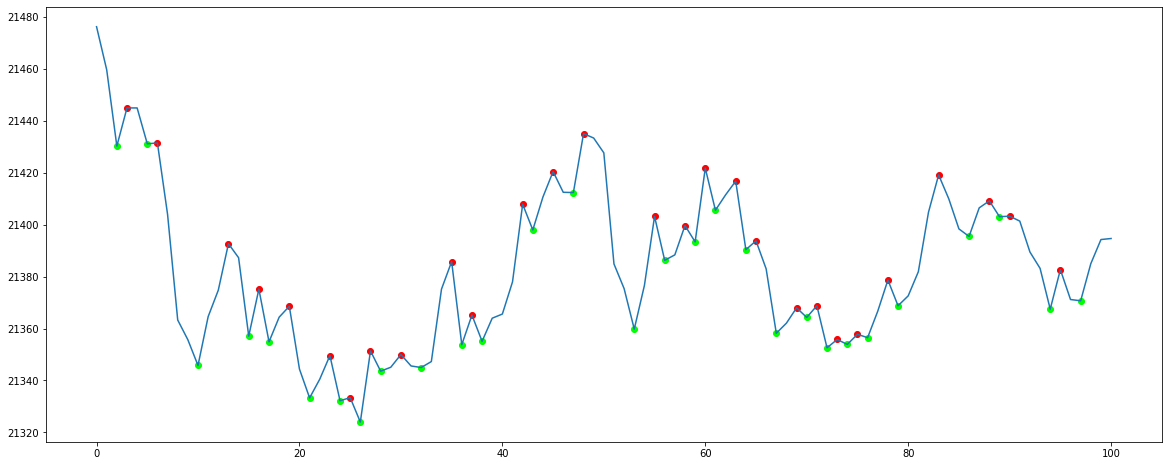

In [404]:
plt.figure(figsize = (20, 8))
plt.plot(df_total.loc[:100, 'open_perp'])

temp = df_total.loc[
    df_total['is_extremum'] & 
    (df_total.index < 100) & 
    (df_total['short_long'] == 1), 
    ['open_perp','is_extremum', 'short_long']]
plt.scatter(temp.index, temp['open_perp'], c='lime')

temp = df_total.loc[
    df_total['is_extremum'] & 
    (df_total.index<100) & 
    (df_total['short_long'] == -1), 
    ['open_perp','is_extremum', 'short_long']]
plt.scatter(temp.index, temp['open_perp'], c='red')

In [405]:
df_razmetka = df_total[['timestamp', 'open_perp', 'is_extremum']].copy()
df_razmetka.reset_index(inplace=True)
df_razmetka.head()

,index,timestamp,open_perp,is_extremum
0,0,1661248680,21476.3,False
1,1,1661248740,21459.7,False
2,2,1661248800,21430.3,True
3,3,1661248860,21445.0,True
4,4,1661248920,21445.0,False


In [406]:
# # formula calculation
# balance_start = 10000
# open_price = 23000
# position_size = 10000* (1-COMMISSION_RATE) / open_price
# close_price = 24000
# profit = balance_start - (balance_start*0.9992/open_price)*0.9992*(6*open_price - 5*close_price)

profit = balance_start * (np.power(1-COMMISSION_RATE, 2) * (1 + LEVERAGE * (1 - close_price/open_price)) - 1)

In [407]:
df_razmetka.loc[df_razmetka['is_extremum']].head()

,index,timestamp,open_perp,is_extremum
2,2,1661248800,21430.3,True
3,3,1661248860,21445.0,True
5,5,1661248980,21431.2,True
6,6,1661249040,21431.5,True
10,10,1661249280,21345.8,True


In [408]:
COMMISSION_RATE = 0.0008
LEVERAGE = 5
balance = 10000

def calculate_profit(balance, open_price, close_price, commision=COMMISSION_RATE, leverage = LEVERAGE):
    return (balance *
            (np.power(1 - commision, 2) *
            (1 + leverage * abs(1 - close_price/open_price))
            - 1))
  
def get_balance(balance, open_price, close_price, commision=COMMISSION_RATE, leverage = LEVERAGE):
    return (balance * 
            (np.power(1 - commision, 2) *
            (1 + leverage * abs(1 - close_price/open_price))))

In [409]:
min_profitability = 1.0075
min_prof_3contracts = min_profitability * 2 - 1

In [410]:
df_razmetka.head()

,index,timestamp,open_perp,is_extremum
0,0,1661248680,21476.3,False
1,1,1661248740,21459.7,False
2,2,1661248800,21430.3,True
3,3,1661248860,21445.0,True
4,4,1661248920,21445.0,False


In [417]:
iterator = iter(df_total.index[df_total['is_extremum']])
#  skip first value because it wouldnt be an extremum
iterator.__next__()
# (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
(index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
extremums = [index_start]
while True: 
# for i in range(1000):
    index_first_contract, price_first_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
    index_second_contract, price_second_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
    index_third_contract, price_third_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]

    # print(price_first_contract ,price_second_contract )
    balance1 = get_balance(balance, price_start, price_first_contract)
    balance12 = get_balance(balance1, price_first_contract, price_second_contract)
    balance123 = get_balance(balance12, price_second_contract, price_third_contract)

    balance__3 = get_balance(balance, price_start, price_third_contract)
    # print(balance_12_extr, balance_2_extr)

    max_balance = max(balance1, balance123/min_prof_3contracts, balance__3)
    if (max_balance > balance * min_profitability):
        if(max_balance == balance1):    
            extremums.append(index_first_contract)
            price_start = price_first_contract

        elif(max_balance == balance__3):
            iterator = iter(df_total.index[df_total['is_extremum'] & (df_total.index>=index_third_contract)])

        elif(max_balance == balance123/min_prof_3contracts):
            # print(index_first_contract, end=' ')
            extremums.append(index_first_contract)
            iterator = iter(df_total.index[df_total['is_extremum'] & (df_total.index>=index_first_contract)])
            (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
    else:
        pass

    # print( close_now_data['open_perp'], open_data['open_perp'])
    # print(calculate_profit(balance, open_data['open_perp'], close_now_data['open_perp']))

    
    # print()
    # break

StopIteration: 

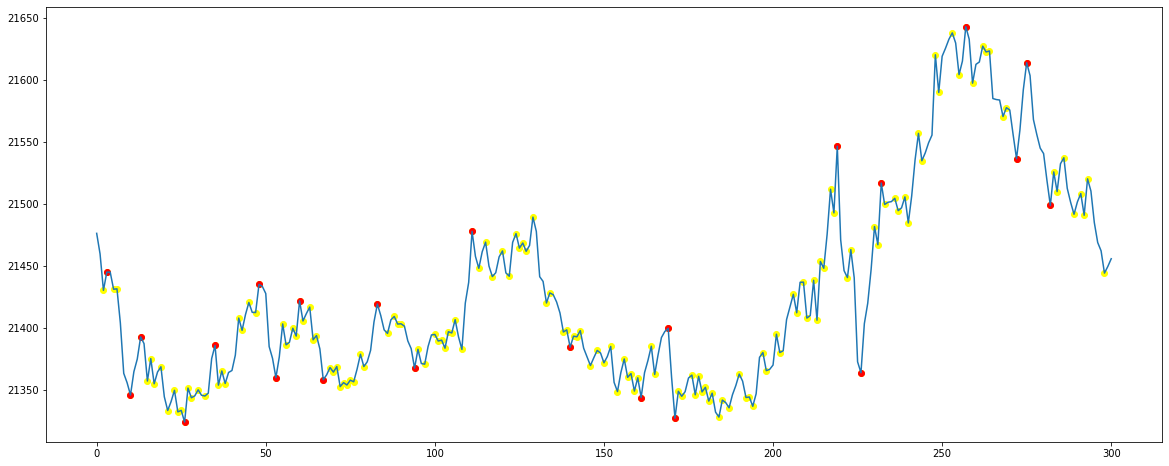

In [418]:
window = 300

plt.figure(figsize = (20, 8))
plt.plot(df_total.loc[:window, 'open_perp'])
extremums = pd.Series(extremums)
plt.scatter(df_total.loc[df_total['is_extremum'] & (df_total.index<window)].index, 
            df_total.loc[df_total['is_extremum'] & (df_total.index<window), 'open_perp'], 
            c='yellow')
plt.scatter(extremums[extremums<window], df_total.loc[extremums[extremums<window], 'open_perp'], c='red')

In [419]:
df_razmetka.loc[extremums, 'extr1'] = True
df_razmetka.fillna(False, inplace=True)

In [420]:
all_extr = df_razmetka.loc[df_razmetka['is_extremum']].copy()
extr1 = df_razmetka.loc[df_razmetka['extr1']].reset_index(drop=True).copy()
non_extr1 = df_razmetka.loc[(~df_razmetka['extr1']) & df_razmetka['is_extremum']].copy()

extr1.head()

,index,timestamp,open_perp,is_extremum,extr1
0,3,1661248860,21445.0,True,True
1,10,1661249280,21345.8,True,True
2,13,1661249460,21392.7,True,True
3,26,1661250300,21324.0,True,True
4,35,1661250840,21385.8,True,True


In [ ]:
start = 0
while True:
    left = extr1.loc[start, ['index', 'open_perp']]
    mid = extr1.loc[start+1, ['index', 'open_perp']]
    right = extr1.loc[start+2, ['index', 'open_perp']]
    
    print(f"{left['index']:>3} ({left['open_perp']}) {mid['index']:>3} ({mid['open_perp']}) {right['index']:>3} ({right['open_perp']})", end = ' ')
    extrema_range = all_extr.loc[left['index']:right['index']]

    if left['open_perp'] > mid['open_perp']:
        print('min')
        index_extrema = extrema_range['open_perp'].idxmin()
    elif left['open_perp'] < mid['open_perp']:
        print('max')
        index_extrema = extrema_range['open_perp'].idxmax()
    else:
        print('drop')
        extr1.drop(extr1.index[extr1['index'] == mid['index']])
        continue

    extrema_range = all_extr.loc[left['index']:right['index']]
    if index_extrema == mid['index']:
        start += 1
        continue
    elif index_extrema == right['index']:
        extr1 = extr1.drop(start+1).reset_index(drop=True)
        continue
    else:
        print(f"replace extrema {mid['index']} on {index_extrema}")
        display(extr1.loc[start+1])
        extr1.loc[start+1] = extrema_range.loc[index_extrema]
        display(extr1.loc[start+1])
        start += 1
        continue

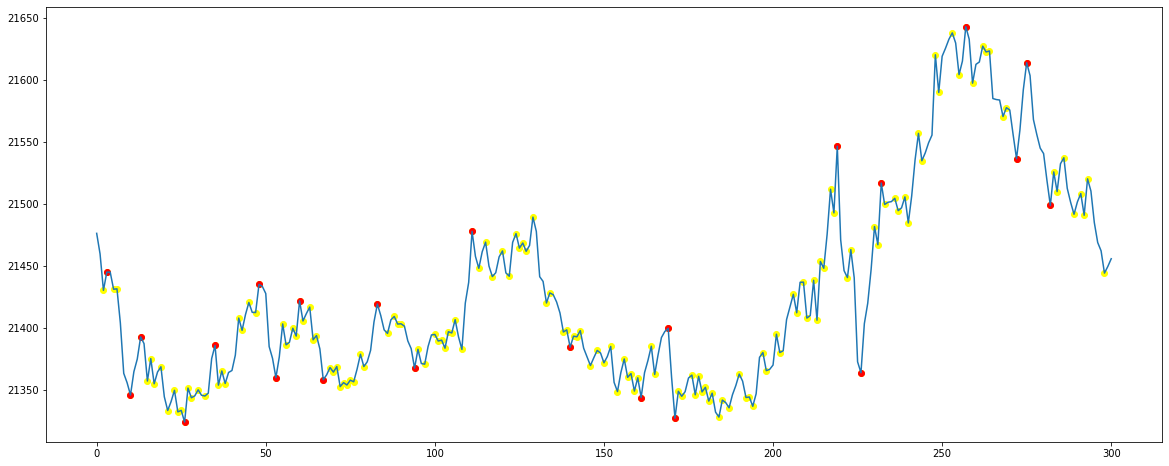

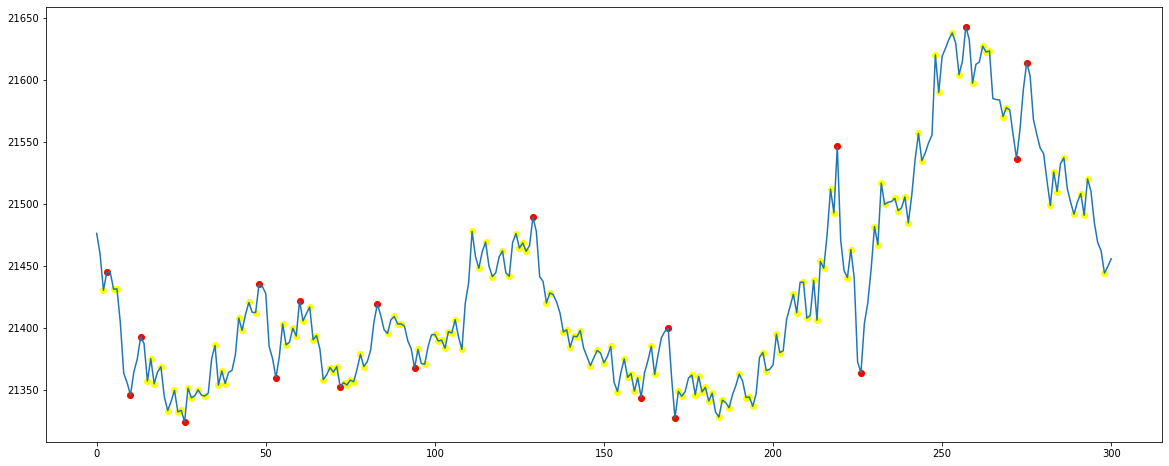

In [422]:
window = 300

plt.figure(figsize = (20, 8))
plt.plot(df_total.loc[:window, 'open_perp'])
extremums = pd.Series(extremums)
plt.scatter(df_total.loc[df_total['is_extremum'] & (df_total.index<window)].index, 
            df_total.loc[df_total['is_extremum'] & (df_total.index<window), 'open_perp'], 
            c='yellow')
plt.scatter(extremums[extremums<window], df_total.loc[extremums[extremums<window], 'open_perp'], c='red')


plt.figure(figsize = (20, 8))
plt.plot(df_total.loc[:window, 'open_perp'])
extremums_new = extr1['index']
plt.scatter(df_total.loc[df_total['is_extremum'] & (df_total.index<window)].index, 
            df_total.loc[df_total['is_extremum'] & (df_total.index<window), 'open_perp'], 
            c='yellow')
plt.scatter(extremums_new[extremums_new<window], df_total.loc[extremums_new[extremums_new<window], 'open_perp'], c='red')

In [435]:
df_total.shape[0], extr1['index'].shape

(346907, (14703,))

In [428]:
346907 / 14703

23.594300482894646

## Archive

In [267]:
# # for left, mid, right in zip(new_extremums[:-2], new_extremums[1:-1], new_extremums[2:]):
# non_extremums = pd.Series(list(set(df_total.index[df_total['is_extremum']]) - set(extremums) - set([2])))
# non_extremums.head()

# new_extremums = extremums.copy()
# start = 0
# while True:
#     new_extremums.reset_index(inplace=True, drop=True)
#     # print(new_extremums.head())
#     left, mid, right = new_extremums.index[start], new_extremums.index[start+1], new_extremums.index[start+2]
#     print(f"{start} - {new_extremums[left]:>3} ({df_total.loc[left, 'open_perp']}) {new_extremums[mid]} ({df_total.loc[mid, 'open_perp']}) {new_extremums[right]} ({df_total.loc[right, 'open_perp']})", end = '   ')
#     points_inbetween = non_extremums[(non_extremums > left) & (non_extremums < right)]
#     all_points = pd.concat([points_inbetween, pd.Series([left, mid, right])])
#     if (df_total.loc[new_extremums[left], 'open_perp'] > df_total.loc[new_extremums[mid], 'open_perp']):
#         print('min')
#         new_minima = df_total.loc[all_points, 'open_perp'].idxmin()
#         if new_minima == new_extremums[mid]:
#             start += 1
#             continue
#         elif new_minima == new_extremums[right]:
#             new_extremums.pop(new_extremums[start+1])
#             continue
#         else:
#             new_extremums[start+1] = new_minima
#             start += 1
#             continue
#     elif (df_total.loc[new_extremums[left], 'open_perp'] < df_total.loc[new_extremums[mid], 'open_perp']):
#         print('max')
#         new_maxima = df_total.loc[all_points, 'open_perp'].idxmax()
#         if new_maxima == new_extremums[mid]:
#             start += 1
#             continue
#         elif new_maxima == new_extremums[right]:
#             new_extremums.pop(new_extremums[start+1])
#             continue
#         else:
#             new_extremums[start+1] = new_maxima
#             start += 1
#             continue
#     else:
#         print('drop')
#         new_extremums.pop(new_extremums.index[mid])
#         continue
    
        

0 -   3 (21476.3) 10 (21459.7) 13 (21430.3)   min
1 -   2 (21459.7) 13 (21430.3) 26 (21445.0)   min
2 -   2 (21430.3) 26 (21445.0) 35 (21445.0)   min
3 -   2 (21445.0) 35 (21445.0) 48 (21431.2)   min
4 -   5 (21445.0) 48 (21431.2) 53 (21431.5)   max
5 -   4 (21431.2) 53 (21431.5) 60 (21404.0)   min
6 -   7 (21431.5) 60 (21404.0) 67 (21363.3)   max
7 -   6 (21404.0) 67 (21363.3) 83 (21355.7)   min
8 -   9 (21363.3) 83 (21355.7) 94 (21345.8)   max
9 -   8 (21355.7) 94 (21345.8) 111 (21364.6)   max
10 -  11 (21345.8) 111 (21364.6) 140 (21374.8)   max
11 -  12 (21364.6) 140 (21374.8) 161 (21392.7)   max
12 -  13 (21374.8) 161 (21392.7) 169 (21387.3)   min
13 -  12 (21392.7) 169 (21387.3) 171 (21357.1)   max
14 -  13 (21387.3) 171 (21357.1) 219 (21375.2)   min
15 -  15 (21357.1) 219 (21375.2) 226 (21354.9)   max
16 -  16 (21375.2) 226 (21354.9) 232 (21364.4)   min
17 -  17 (21354.9) 232 (21364.4) 257 (21368.6)   max
18 -  19 (21364.4) 257 (21368.6) 272 (21344.4)   max
19 -  19 (21368.6) 272

IndexError: index 36 is out of bounds for axis 0 with size 36